In [1]:
import torch
import numpy as np
from misc import *
from hsic import *
from convmodel import *
from load_data import *
from train import *
torch.cuda.is_available()

c:\Users\Anubhav\anaconda3\envs\mytorch112\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


True

In [2]:
import sys
print(sys.version)

3.8.0 (default, Nov  6 2019, 16:00:02) [MSC v.1916 64 bit (AMD64)]


In [3]:
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import datetime
import os
import torchvision
import time
import copy

from tqdm import tqdm

In [4]:
torch.__version__

'1.12.1+cu116'

# Implement the basic form of the paper’s proposal (HSIC-trained Network as seen in Fig. 1a) and train on MNIST and CIFAR-10.

So, the first task is to read and implement kernel-based Hilbert Schmidt independence bottleneck basic technique for replacing Backpropagation. The notebook contains the training code for CNN with HSIC objective function (Eq. 3). The supporting functions are split across 5 python files:

1. Hsic.py: Contains code for calculation of kernel matrix, Equation 3 from the paper, and the HISC objective function. 

2. load_data.py: Contains code for loading MNIST and CIFAR10 datasets.

3. convmodel.py: contains the CNN network used for training the unformat version of HSIC and Ensemble (CNN + softmax without backprop.) for formatted HSIC for classification.

4. train.py: Contains code for training unformat and format version of HSIC.

5. misc.py: contains miscelleneous code. 

# MNIST Training

In [19]:
config_dict = {}
config_dict['batch_size'] = 128
config_dict['learning_rate'] = 0.001
config_dict['n_layers'] = 5 # Number of hidden convolutional layers
config_dict['hidden_width'] = 128
config_dict['epochs'] = 15

config_dict['seed'] = 1234
config_dict['device'] = 'cuda'
config_dict['atype'] = 'relu'
config_dict['data_code'] = 'mnist'

config_dict['lambda_y'] = 100.
config_dict['sigma'] = 5.
config_dict['task'] = 'hsic-train'
config_dict['log_batch_interval'] = 10
config_dict['ext'] = 'pdf'

In [ ]:
# So first task is to train the HSIC bottleneck model by minimizing the HSIC object function (Unformat version.) and store the learned weights. 

batch_log_list, epoch_log_dict = training_hsic(config_dict)

In [ ]:
# Then, load the trained weights from unformat training and add a linear layer with softmax  for classification. Note: freeze the learned weights from unformat version and only update the linear weights. 

# More details are in the train.training_format() function.

loadPath = r"Huawei\mnist\exp_20221101-230528\reports\model\model---0015.pt"
config_dict = {}
config_dict['batch_size'] = 128
config_dict['learning_rate'] = 0.001
config_dict['n_layers'] = 5 # Number of hidden convolutional layers
config_dict['hidden_width'] = 128
config_dict['epochs'] = 50

config_dict['seed'] = 1234
config_dict['device'] = 'cuda'
config_dict['atype'] = 'relu'
config_dict['data_code'] = 'mnist'

config_dict['lambda_y'] = 100.
config_dict['sigma'] = 5.
config_dict['task'] = 'hsic-train'
config_dict['log_batch_interval'] = 10
config_dict['ext'] = 'pdf'

batch_log_list, epoch_log_dict = training_format(config_dict, loadPath)

# CIFAR10

In [40]:
# perform the same training schedule used for MNIST for CIFAR10 as well.

config_dict = {}
config_dict['batch_size'] = 128
config_dict['learning_rate'] = 0.001
config_dict['n_layers'] = 5 # Number of hidden convolutional layers
config_dict['hidden_width'] = 128
config_dict['epochs'] = 15

config_dict['seed'] = 1234
config_dict['device'] = 'cuda'
config_dict['atype'] = 'relu'
config_dict['data_code'] = 'cifar10'

config_dict['lambda_y'] = 100.
config_dict['sigma'] = 5.
config_dict['task'] = 'hsic-train'
config_dict['log_batch_interval'] = 10
config_dict['ext'] = 'pdf'

In [ ]:
batch_log_list, epoch_log_dict = training_hsic(config_dict)

In [ ]:
loadPath = r"Huawei\cifar10\exp_20221102-160343\reports\model\model---0015.pt"
config_dict = {}
config_dict['batch_size'] = 128
config_dict['learning_rate'] = 0.001
config_dict['n_layers'] = 5 # Number of hidden convolutional layers
config_dict['hidden_width'] = 128
config_dict['epochs'] = 50

config_dict['seed'] = 1234
config_dict['device'] = 'cuda'
config_dict['atype'] = 'relu'
config_dict['data_code'] = 'cifar10'

config_dict['lambda_y'] = 100.
config_dict['sigma'] = 5.
config_dict['task'] = 'hsic-train'
config_dict['log_batch_interval'] = 10
config_dict['ext'] = 'pdf'

batch_log_list, epoch_log_dict = training_format(config_dict, loadPath)

# Training and Testing Plots for MNIST and CIFAR10

In [48]:
def extract_epoch_logs(log):

    train_acc = log.item()['epoch_log_dict']['train_acc']
    train_loss = log.item()['epoch_log_dict']['train_loss']
    
    test_acc = log.item()['epoch_log_dict']['test_acc']
    test_loss = log.item()['epoch_log_dict']['test_loss']

    return train_acc, train_loss, test_acc, test_loss

def load_logs(data_code, experiment_number):
    load_path = r"Huawei\HSIC_basic\assets\{}\{}\reports\report\Ensem_log---0050.npy".format(data_code, experiment_number)

    elog = np.load(load_path, allow_pickle=True)

    train_acc, train_loss, test_acc, test_loss = extract_epoch_logs(elog)

    return train_acc, train_loss, test_acc, test_loss


In [119]:
import matplotlib.pyplot as plt

def plot_training(epoch_logs, data_code='mnist', title=None, xlabel=None, ylabel=None):
    
    fig = plt.figure(constrained_layout=True, figsize=(10,5))
    ax = fig.add_subplot(121)
    px = fig.add_subplot(122)

    p1 = ax.plot(epoch_logs[0], linewidth=1, label='Training')
    ax.plot(epoch_logs[0], '*', ms = 5, alpha = 0.7, color = p1[0].get_color())

    p2 = ax.plot(epoch_logs[1], linewidth=1, label='Testing')
    ax.plot(epoch_logs[1], '+', ms = 5, alpha = 0.7, color = p2[0].get_color())


    l1 = px.plot(epoch_logs[2], linewidth=1, label='Training')
    px.plot(epoch_logs[2], '+', ms = 5, alpha = 0.7, color = l1[0].get_color())

    l2 = px.plot(epoch_logs[3], linewidth=1, label='Testing')
    px.plot(epoch_logs[3], '+', ms = 5, alpha = 0.7, color = l2[0].get_color())

    ax.set_title(title[0], fontsize=15)
    ax.set_ylim((0, 101))
    ax.set_xlabel(xlabel[0], fontsize=10)
    ax.set_ylabel(ylabel[0], fontsize=10)

    px.set_title(title[1], fontsize=15)
    # px.set_ylim((0, 101))
    px.set_xlabel(xlabel[1], fontsize=10)
    px.set_ylabel(ylabel[1], fontsize=10)

    ax.legend(fontsize=10, loc='upper right')
    px.legend(fontsize=10, loc='upper right')

    plt.show()


## Plots for MNIST

The plots below (Left) shows the accuracy vs. epoch and loss vs. epoch (Right) for training and test set for MNIST and CIFAR10. We can observe that the training and test accuracy increases while the loss decreases gradually with the epochs. Note: the epochs shown here corresponds to the format training. Further, experiments can be done to show the impact of performing unformat training for different epochs on the performance. 

In [49]:
# Load log files for mnist

data = ['mnist', 'cifar10']
data_code = {'mnist':'exp_20221101-233947', 'cifar10':'exp_20221102-224915'}

train_acc, train_loss, test_acc, test_loss = load_logs('mnist', data_code['mnist'])

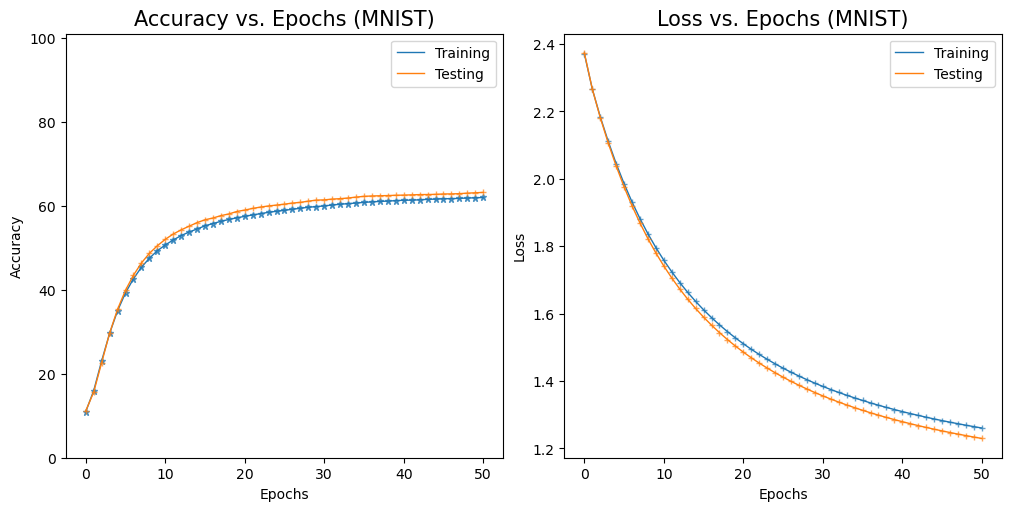

In [120]:
data_plot = [train_acc, test_acc, train_loss, test_loss]
plot_title = ['Accuracy vs. Epochs (MNIST)', 'Loss vs. Epochs (MNIST)']

plot_training(data_plot, 'mnist', plot_title, ['Epochs', 'Epochs'], ['Accuracy', 'Loss'])

## Plots for CIFAR10

In [121]:
# Load log files for cifar10

data = ['mnist', 'cifar10']
data_code = {'mnist':'exp_20221101-233947', 'cifar10':'exp_20221102-224915'}

train_acc, train_loss, test_acc, test_loss = load_logs('cifar10', data_code['cifar10'])

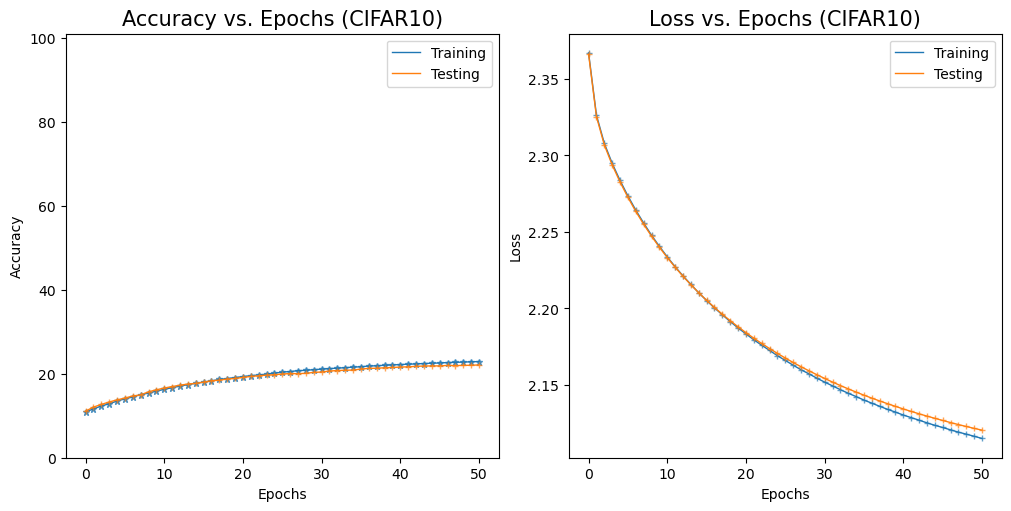

In [122]:
data_plot = [train_acc, test_acc, train_loss, test_loss]
plot_title = ['Accuracy vs. Epochs (CIFAR10)', 'Loss vs. Epochs (CIFAR10)']

plot_training(data_plot, 'mnist', plot_title, ['Epochs', 'Epochs'], ['Accuracy', 'Loss'])

# TASK 3: 

## After implementing HSIC training, write a concise review of the paper from your own perspective. Discuss what the paper does well and what it falls short on.

The paper introduces the HSIC (Hilbert-Schmidt independence criterion) bottleneck for training deep neural networks. In the paper, the authors have presented an objective function: HSIC bottleneck as an alternative to cross-entropy and backpropagation. Suppose the hidden representations are represented as Z (neural nets weights), the input as X, and the output representations as Y. Then, in principle, the authors suggest that we seek the hidden representations Z that are less dependent on the input representation X and more dependent on the output representation Y. As, based on the HSIC bottleneck (eq. 3), we have the objective function, we can directly compute the gradients of the weights in the forward pass without the requirement of backpropagation. The paper illustrates the robustness of the introduced HSIC bottleneck-based objective function by comparing the performance with the backpropagation. Experiments show that for deep networks, the performance of the backpropagated model degrades significantly compared to HSIC based model, highlighting the issue of vanishing gradients in deep networks. The authors might have included additional examples of their research using state of the art architectures. The behaviour of the HSIC bottleneck in architectures with residual connections, such as ResNets, etc., would have been interesting to observe. Additionally, more experiments can be conducted to demonstrate the speed and resource savings over backpropagation.

# Task 6:

## Discuss how you envision or theorize this training can be used in practical application, in potential future technologies. Consider how this training method can be used in ways in which traditional back  ropagation cannot.

HSIC bottleneck technique can be used in conjuction with Distributed Deep Learning. By using HSIC and DDL in conjuction, the overall deep learning computation time can be reduced as mentioned in [1]. The authors of [1] mention the application of DDL with HSIC bottleneck can be suitale for load forecasting in smart grids. As backpropagation is computationally expensive in terms of cost and time, use of HSIC in with DDL based load forcasting can reduce computational cost and time. 

[1] Akhtaruzzaman, Md, et al. "HSIC bottleneck based distributed deep learning model for load forecasting in smart grid with a comprehensive survey." IEEE Access 8 (2020): 222977-223008.


# Task 4:

## Explore some methods to improve upon the basic HSIC training you have implemented, whether that improvement is in terms of computation speed, training speed, or overall machine learning performance, etc. Try to take what you have implemented towards a new direction in some way, however big or small. Show that you understand how this machine learning approach works, and how you can improve upon it. State your reasoning.

The training performance can be increased by training the layers with HSIC objective function in parallel using layerwise block coordinate descent. 

To extent the HSIC bottleneck, it can be used as regularizer in conjuction with the defaul log loss (cross-entropy) for learning robust deep neural networks.